### Choose Partially Observable or Fully Occluded Config

In [1]:
cname = "myscene_trans_rot_no_obs" #'myscene_trans_rot_part_obs'

In [2]:
import os
os.chdir('/home/shashank/code/packages/diff-dope')
import matplotlib.pyplot as plt
from icecream import ic
from hydra import initialize, compose
import numpy as np
from theseus.geometry import SO3
import torch
import pybullet as p
from scipy.spatial.transform import Rotation
import diffdope as dd
from diffdope.pcd_utils import *
from diffdope import *
import copy
import meshcat
import meshcat.geometry as mcg
from typing import List, Tuple
import cv2
import trimesh
import open3d as o3d
import pprint
with initialize(version_base=None, config_path="../configs/"):
    cfg = compose(config_name=cname)

#run meshcat otherwise notebook will be stuck here
mc_vis = meshcat.Visualizer(zmq_url='tcp://127.0.0.1:6000') 
mc_vis.delete()

/home/shashank/miniconda3/envs/rpdiff-env/lib/python3.8/site-packages/theseus/_version.py:30: FutureWarning: Using torch < 2.0 for theseus is deprecated and compatibility will be discontinued in future releases.
  warnings.warn(
pybullet build time: May 20 2022 19:44:17



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
def noise_pose(gt_pos,gt_rot,sigma_t,sigma_r):
    p = torch.from_numpy(gt_pos).float()
    R = torch.from_numpy(Rotation.from_quat(gt_rot).as_matrix()).float()
    nr = torch.randn(1,3) * sigma_r
    nR = torch.matmul(SO3().exp_map(nr).to_matrix(),R)
    nP = torch.randn_like(p) * sigma_t + p
    npose = np.zeros((7,))
    npose[:3] = nP.numpy()
    npose[3:] = Rotation.from_matrix(nR.numpy()).as_quat()
    return npose

def pose_to_T44(p,q):
    t = np.eye(4)
    t[:3,-1] = p
    if len(q) == 4:
        t[:3,:3] = Rotation.from_quat(q).as_matrix()
    if len(q) == 3:
        t[:3,:3] = SO3().exp_map(torch.from_numpy(q).view(-1,3)).to_matrix().numpy()
    return t
def T44_to_pose(T):
    pose = np.zeros((7,))
    pose[:3] = T[:3,-1]
    pose[3:] = Rotation.from_matrix(T[:3,:3]).as_quat()
    return pose

In [4]:
def get_cfg(cfg,
            camera_info,
            model_path,
            file_path,
            parent_id,
            object_id,
            position,rotation):
    ############# CAMERA PARAMS ##############
    cfg['camera']['im_height'] = camera_info['height']
    cfg['camera']['im_width'] = camera_info['width']
    cfg['camera']['znear'] = camera_info['nearVal'] 
    cfg['camera']['zfar'] = camera_info['farVal']
    cfg['camera']['fov'] = camera_info['fov']
    ############ INITIAL POSE ################
    cfg['object3d']['position'] = position.tolist()
    cfg['object3d']['rotation'] = rotation.tolist()
    ############# DATA PARAMS ###################
    cfg['scene']['dataset_path'] = file_path
    cfg['scene']['parent_id'] = parent_id
    cfg['scene']['object_id'] = object_id
    cfg['object3d']['model_path'] = model_path
    return cfg

### Choose data

{1: 'tray',
 2: '051_large_clamp',
 3: '009_gelatin_box',
 4: '037_scissors',
 5: '021_bleach_cleanser',
 6: '002_master_chef_can',
 7: '008_pudding_box',
 8: '052_extra_large_clamp',
 9: '019_pitcher_base',
 10: '036_wood_block'}


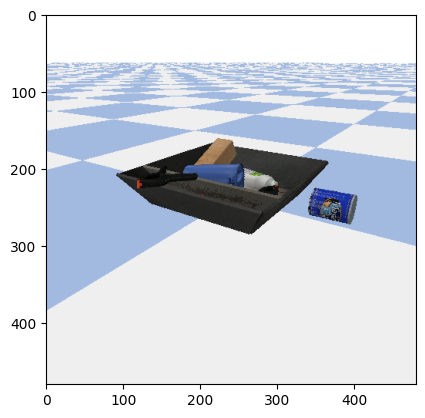

In [5]:
parent_id = '110'
file_path = '/home/shashank/code/packages/rpdiff/src/rpdiff/data/task_demos/cluttered_tabletop/0/'
dfile = np.load(file_path + f'{parent_id}.npz',allow_pickle=True)[parent_id].item()
pprint.pprint(dfile['objects'])
plt.imshow(dfile['img_arr'][0])

In [6]:
#which objects are fully occluded in the scene? 
visible = np.unique(dfile['img_arr'][2])
invisible = list(set(dfile['objects'].keys()).difference(set(visible)))
print(invisible)

[4]


choose the object ID from the objects dict above to select the object \
For fully occluded case, select an object that is fully occluded (e.g.: parent_id:110, object_id: 4)

In [7]:
object_id = 4 
object_name = dfile['objects'][object_id]
print(f'{object_id}:{object_name}')
model_path = f'/home/shashank/code/packages/rpdiff/src/rpdiff/assets/ycb/{object_name}/textured_simple.obj'
opcd = np.asarray(o3d.io.read_triangle_mesh(model_path).sample_points_uniformly(500).points)
omesh = trimesh.load(model_path)

4:037_scissors


In [8]:
camera_info = dfile['camera_info']
view_matrix = p.computeViewMatrix(camera_info['cam_eye'],camera_info['lookat'],camera_info['up'])
view_matrix = np.asarray(view_matrix,order='F').reshape([4,4],order='F')
inv_view_matrix = np.linalg.inv(view_matrix)
poses = dfile['poses']
gt_pose_world = np.array(poses[object_name])[0]
gt_pose_world = pose_to_T44(gt_pose_world[:3],gt_pose_world[3:])
gt_pose_cam_t44 = np.matmul(view_matrix,gt_pose_world)
gt_pose_cam_rtheta = SO3(tensor=torch.from_numpy(gt_pose_cam_t44[:3,:3]).unsqueeze(0)).log_map().squeeze()
gt_pose_cam = T44_to_pose(gt_pose_cam_t44)
print(f'GT Camera Frame position:{gt_pose_cam[:3]}')
print(f'GT Camera Frame Orientation: {gt_pose_cam[3:]}')
print(f'GT Camera Frame rtheta: {gt_pose_cam_rtheta}')

GT Camera Frame position:[-0.02839774 -0.0428986  -1.05992616]
GT Camera Frame Orientation: [ 0.50419879  0.12403628 -0.4730411   0.71177995]
GT Camera Frame rtheta: tensor([ 1.1180,  0.2750, -1.0489], dtype=torch.float64)


In [9]:
## variance for pose noising
sigma_r = 1.0
sigma_t = 0.2

### (For Partially/Fully Observable) Find a noisy initial pose with mask intersection

In [10]:
while True:
    noised_pose = noise_pose(gt_pose_cam[:3],gt_pose_cam[3:],sigma_t,sigma_r)
    position = copy.deepcopy(noised_pose[:3])
    rotation = copy.deepcopy(noised_pose[3:])
    
    #Use these for setting a fully occluded
    #object to an initial pose where it is observable
    #position[0]-=0.3
    position[1]+=0.3
    position[2]-=0.3

    cfg = get_cfg(
        cfg,
        camera_info,
        model_path,
        file_path,
        parent_id,
        object_id,
        position,rotation
    )
    ### Initialize
    ddope = dd.DiffDope(cfg=cfg)
    B = ddope.batchsize
    result = ddope.object3d()

    if ddope.object3d.rotation_mode=='rtheta':
        mtx_gu = dd.matrix_batch_44_from_position_r(
            p=result["trans"], r=result["rtheta"]
        )
    else:
        mtx_gu = dd.matrix_batch_44_from_position_quat(
            p=result["trans"], q=result["quat"]
        )
    renders = dd.render_texture_batch(
        glctx=ddope.glctx,
        proj_cam=ddope.camera.cam_proj,
        mtx=mtx_gu,
        pos=result["pos"],
        pos_idx=result["pos_idx"],
        uv=result["uv"],
        uv_idx=result["uv_idx"],
        tex=result["tex"],
        resolution=ddope.resolution,   
    )
    
    seg_gt = ddope.gt_tensors["segmentation"].cpu()
    mask = renders["mask"][0].detach().cpu()
    diff_mask = torch.abs(mask- ddope.gt_tensors["segmentation"].cpu())
    
    if 'part_obs' in cname:
        if torch.any(mask[seg_gt.gt(0)].gt(0)): #check if the inital pose mask has intersection
            print(f'Noised Position: {position}')
            print(f'Noised Rotation: {rotation}')
            print(f'Position Noise:{sigma_t}')
            print(f'Rotation Noise:{sigma_r}')
            break
    else:
        break    
pprint.pprint(f"Learning Rates used: {ddope.learning_rates}")    

Using /home/shashank/.cache/torch_extensions/py38_cu116 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/shashank/.cache/torch_extensions/py38_cu116/renderutils_plugin/build.ninja...
Building extension module renderutils_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module renderutils_plugin...


('Learning Rates used: tensor([0.1934, 0.3345, 0.0104, 0.3864, 0.0240, 0.2576, '
 '0.2080, 0.4320, 0.4128,\n'
 '        0.4491, 0.3451, 0.0840, 0.2313, 0.1512, 0.0204, 0.2059],\n'
 "       device='cuda:0')")


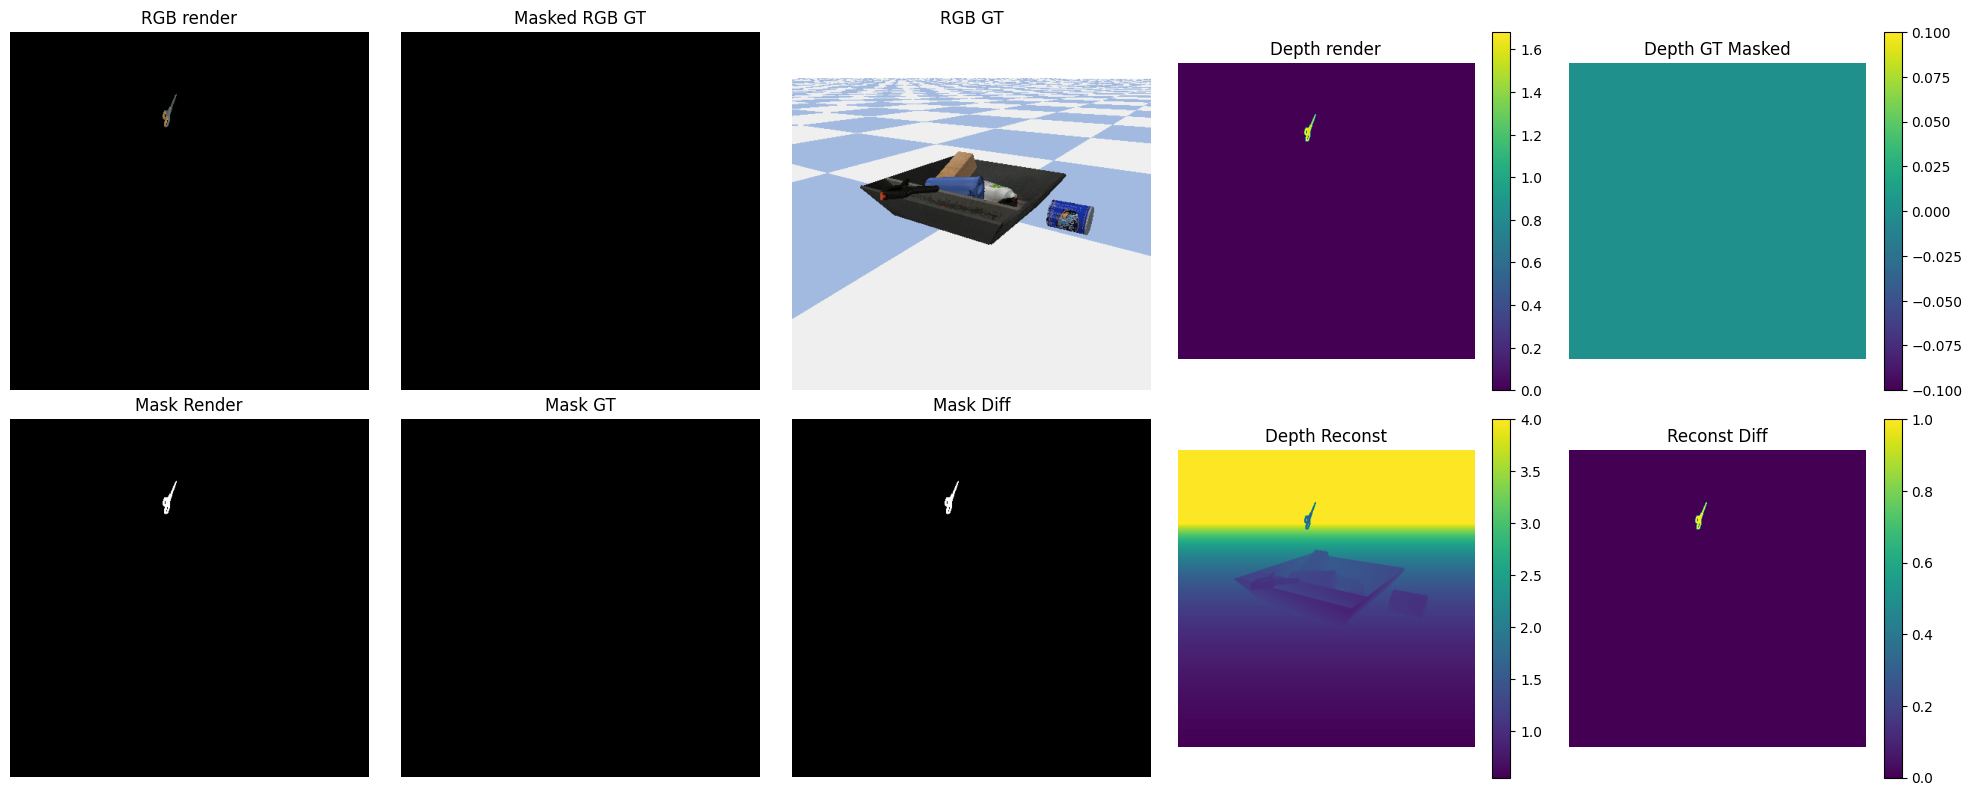

In [11]:
pt44 = pose_to_T44(position,rotation)
obj_cam = np.matmul(pt44[:3,:3],opcd.T).T + pt44[:3,-1]
obj_world = np.matmul(gt_pose_world[:3,:3],opcd.T).T+gt_pose_world[:3,-1]
meshcat_pcd_show(mc_vis,obj_cam,(255,0,255),'obj_cam')
obs_cam = np.matmul(view_matrix[:3,:3],dfile['obs']['points'].T).T + view_matrix[:3,-1]
meshcat_pcd_show(mc_vis,obs_cam,(255,0,0),'obs_cam')

rgb_render = renders['rgb'][0].detach().cpu()
rgb_gt = ddope.gt_tensors["rgb"].cpu()
depth_render = renders['depth'][0].detach().cpu()
depth_gt = ddope.gt_tensors["depth"].cpu()
seg_gt = ddope.gt_tensors["segmentation"].cpu()
mask = renders["mask"][0].detach().cpu()
diff_mask = torch.abs(mask- ddope.gt_tensors["segmentation"].cpu())
#reconst = torch.abs(
#reconst =  depth_gt.clone()
#depth_diff = (torch.min(depth_gt,depth_render)-depth_gt)*mask[...,0]
#reconst = reconst + depth_diff
reconst = torch.where(mask[...,0]>0,torch.min(depth_gt,depth_render),depth_gt)

titles = [
        'RGB render', 'Masked RGB GT', 'RGB GT', 'Depth render', 'Depth GT Masked',
        'Mask Render','Mask GT', 'Mask Diff', 'Depth Reconst','Reconst Diff'
    ]
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Change the subplot configuration to 2 rows of 5 plots each
for idx, ax in enumerate(axes.flat):
    ax.set_title(titles[idx]) if idx < len(titles) else ax.axis('off')  # Set titles or turn off extra subplot
    ax.axis('off')
# Plotting the images
axes[0, 0].imshow(np.flip(rgb_render.numpy(),[0]))
axes[0, 1].imshow(np.flip((rgb_gt * seg_gt).numpy(),[0]))
axes[0, 2].imshow(np.flip(rgb_gt.numpy(),[0]))
dr = axes[0, 3].imshow(np.flip((depth_render * mask[..., 0]).numpy(),[0]))
dg = axes[0, 4].imshow(np.flip((depth_gt * seg_gt[..., 0]).numpy(),[0]))
axes[1, 1].imshow(np.flip(seg_gt.numpy(),[0]))
axes[1, 0].imshow(np.flip(mask.numpy(),[0]))
axes[1, 2].imshow(np.flip(diff_mask.numpy(),[0]))
drc = axes[1, 3].imshow(np.flip(torch.clip(reconst,max=4.0).numpy(),[0]))
ddrc = axes[1,4].imshow(np.flip(torch.clip((reconst!=depth_gt),max=4.0).numpy(),[0]))
# Adding colorbars to specific subplots
plt.colorbar(dr, ax=axes[0, 3])
plt.colorbar(dg, ax=axes[0, 4])
plt.colorbar(drc, ax=axes[1, 3])
plt.colorbar(ddrc,ax = axes[1,4])
plt.tight_layout()
plt.show()

### Run Optimization

In [12]:
ddope.run_batched_rp_lr_optimization()
ic(ddope.get_argmin(), ddope.get_pose())
print(f'GT pose:{gt_pose_cam_t44}')

[0.3772954336597915, 0.8387955422183392, 0.581685049029943, 0.47542081766698147, 0.948773274160459, 0.5733937049494477, 0.2767738669765291, 0.3182280273046957, 0.6729214385719621, 0.05537876893791122, 0.6897628818316556, 0.05353964904988868, 0.10647701800901906, 0.2619474095111363, 0.7684527038602276, 0.014359624479722003]
[5.7073982876269955, 20.68394550792522, 46.70994464558346, 37.52087769996752, 16.621430230303975, 9.991114365433285, 49.98565489490427, 36.269110906092074, 17.940949565186784, 25.048654035380213, 4.070781561384992, 4.800983324665477, 39.18362283202158, 44.07826931929003, 3.996434412829088, 44.217939585318724]


loss: 0.1068: 100%|██████████| 201/201 [00:07<00:00, 26.46it/s]
ic| ddope.get_argmin(): tensor(4)
    ddope.get_pose(): array([[-0.6604458 , -0.12351596, -0.7406451 , -0.08891831],
                             [-0.6509496 , -0.3974691 ,  0.64674795,  0.30968088],
                             [-0.37426728,  0.9092646 ,  0.18210417, -1.7940643 ],
                             [ 0.        ,  0.        ,  0.        ,  1.        ]],
                            dtype=float32)


GT pose:[[ 0.52169422  0.7984802  -0.30044044 -0.02839774]
 [-0.5483244   0.04403135 -0.83510564 -0.0428986 ]
 [-0.65358658  0.60040862  0.46079711 -1.05992616]
 [ 0.          0.          0.          1.        ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
making video: 100%|██████████| 201/201 [00:19<00:00, 10.56it/s]


Saved animation to simple_scene.mp4


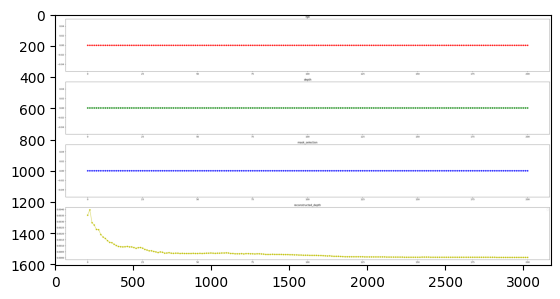

In [13]:
#These are now raw loss values
img_plot = ddope.plot_losses()
cv2.imwrite("plot.png", img_plot)
ddope.make_animation(output_file_path="simple_scene.mp4",batch_index=None)
print("Saved animation to simple_scene.mp4")
opt_results = ddope.optimization_results
#params = ['qx','qy','qz','qw','x','y','z']
params = ['rx','ry','rz','x','y','z']
plt.imshow(img_plot)

Best RGB Loss: 0.0
--------
Best Depth Loss: 0.0
--------
Best Mask Loss: 0.0
Best reconstruction Loss: 3.9807975554140285e-05


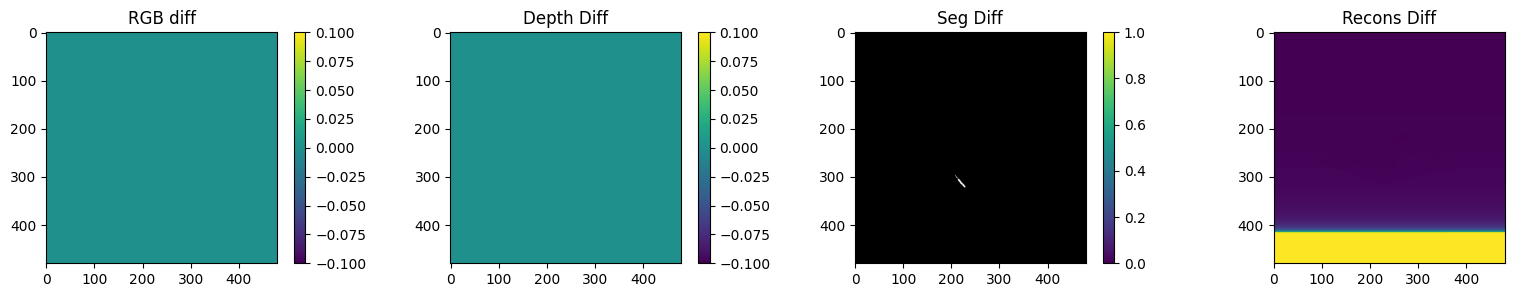

In [14]:
argmi = ddope.get_argmin()
print(f"Best RGB Loss: {ddope.losses_values['rgb'][...,argmi][-1]}")
#print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print("--------")
print(f"Best Depth Loss: {ddope.losses_values['depth'][...,argmi][-1]}")
#print(f"GT Raw Depth Loss:{gt_depth_loss}")
print("--------")
#print(f"GT Raw Mask Loss:{gt_mask_loss}")
print(f"Best Mask Loss: {ddope.losses_values['mask_selection'][...,argmi][-1]}")
#print(f"GT reconstruction Loss: {gt_reconstruct_loss}")
print(f"Best reconstruction Loss: {ddope.losses_values['reconstructed_depth'][...,argmi][-1]}")

best_rgb = ddope.optimization_results[-1]['rgb'][argmi].cuda()
best_depth = ddope.optimization_results[-1]['depth'][argmi].cuda()
best_mask = ddope.optimization_results[-1]['mask'][argmi].cuda()

diff_rgb = torch.abs(
        (best_rgb - ddope.gt_tensors["rgb"])
        * ddope.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (best_depth - ddope.gt_tensors["depth"])
        * ddope.gt_tensors["segmentation"][..., 0]
    )
recons = (torch.where(best_mask[...,0]>0,torch.min(ddope.gt_tensors["depth"],best_depth),ddope.gt_tensors["depth"]))#!=ddope.gt_tensors["depth"])

diff_mask = torch.abs(best_mask - ddope.gt_tensors["segmentation"])

fig,axes = plt.subplots(1,4,figsize=(20,3))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')
axes[3].set_title('Recons Diff')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())
axes[3].imshow(recons[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

#### Plot best and intermediate poses in meshcat

In [15]:
best_pose_T44 = ddope.get_pose(get_all=True)

In [16]:
print(best_pose_T44[-1])
N = 10
step = (len(best_pose_T44) - 1) / (N - 1)
points = [best_pose_T44[int(round(step * i))] for i in range(N)]
for i in range(N):
    meshcat_pcd_show(mc_vis,np.matmul(points[i][:3,:3],opcd.T).T+points[i][:3,-1],(255,255,0),f'intermediate_poses/best_pose_{i}')

meshcat_pcd_show(mc_vis,np.matmul(best_pose_T44[-1][:3,:3],opcd.T).T+best_pose_T44[-1][:3,-1],(255,255,0),f'best_pose')    

[[-0.6604458  -0.12351596 -0.7406451  -0.08891831]
 [-0.6509496  -0.3974691   0.64674795  0.30968088]
 [-0.37426728  0.9092646   0.18210417 -1.7940643 ]
 [ 0.          0.          0.          1.        ]]


### Visualize Gradients

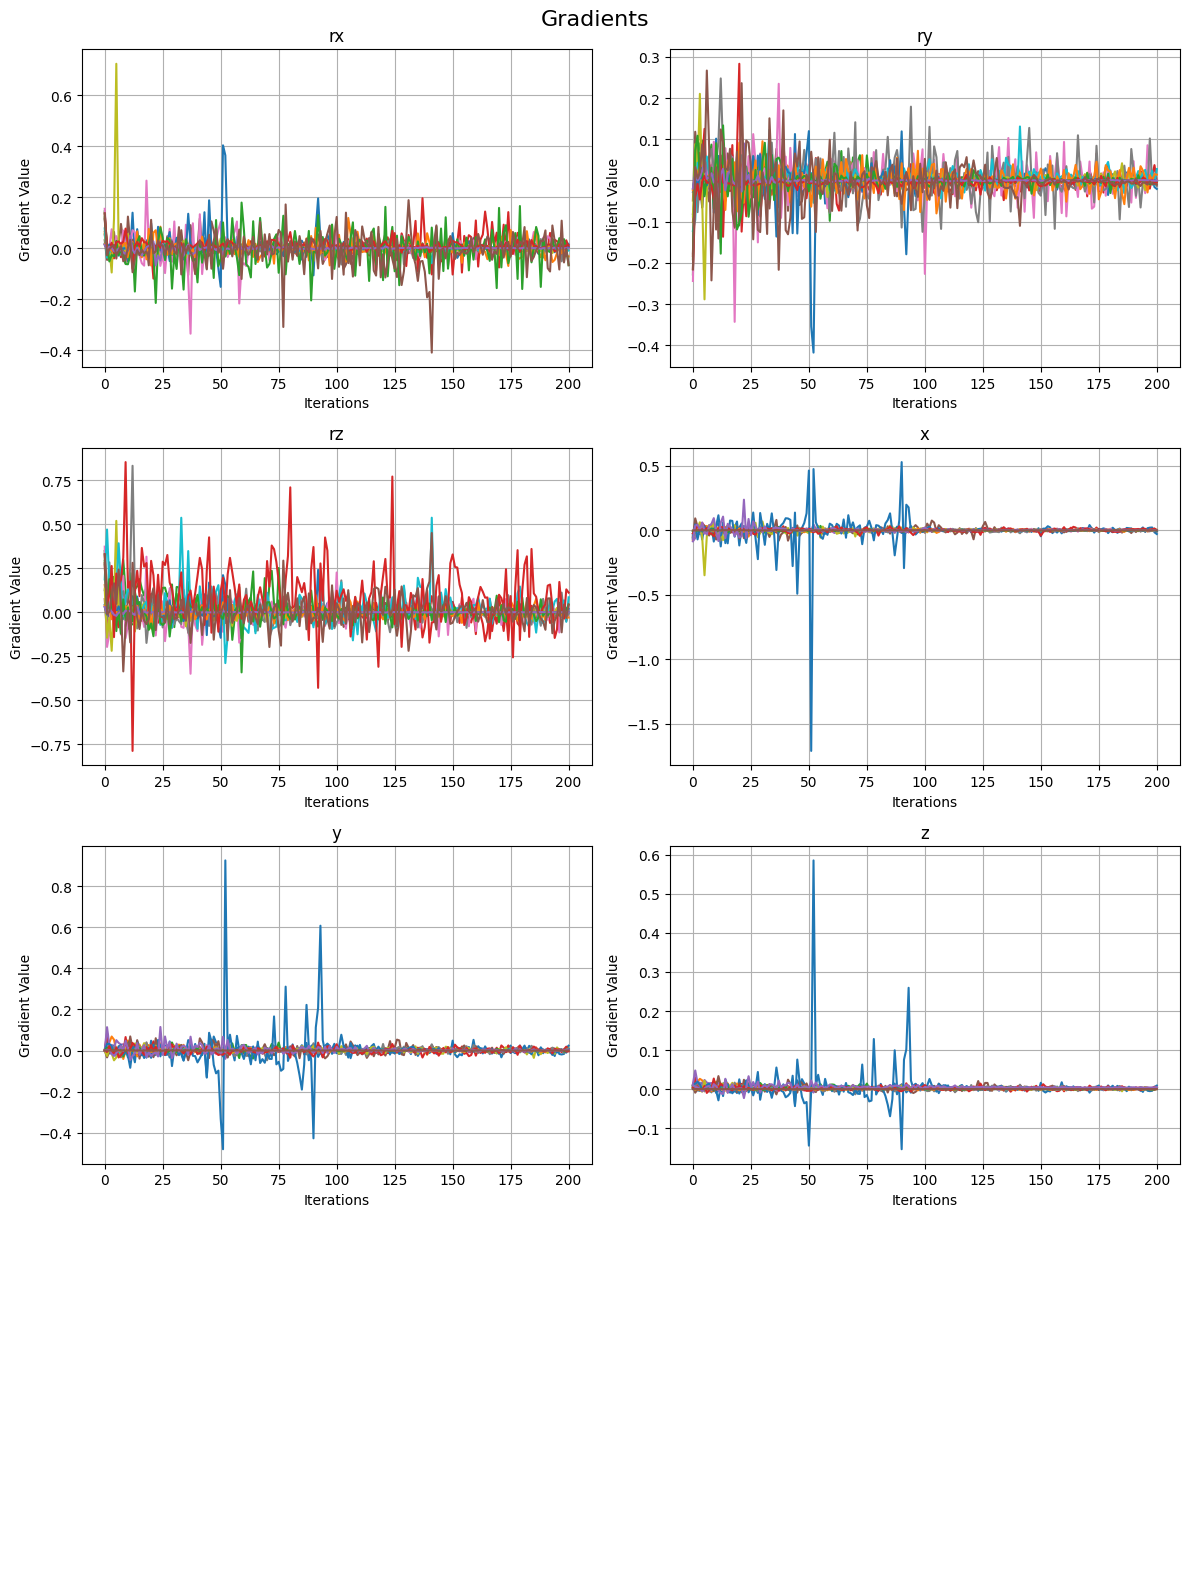

In [17]:
gradients = [o['gradients'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
num_params = len(params)
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed
fig.suptitle('Gradients', fontsize=16)
for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_gradients = [array[:, i] for array in gradients]  # Extract gradients for each parameter
        ax.plot(param_gradients)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Gradient Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


### Visualize values

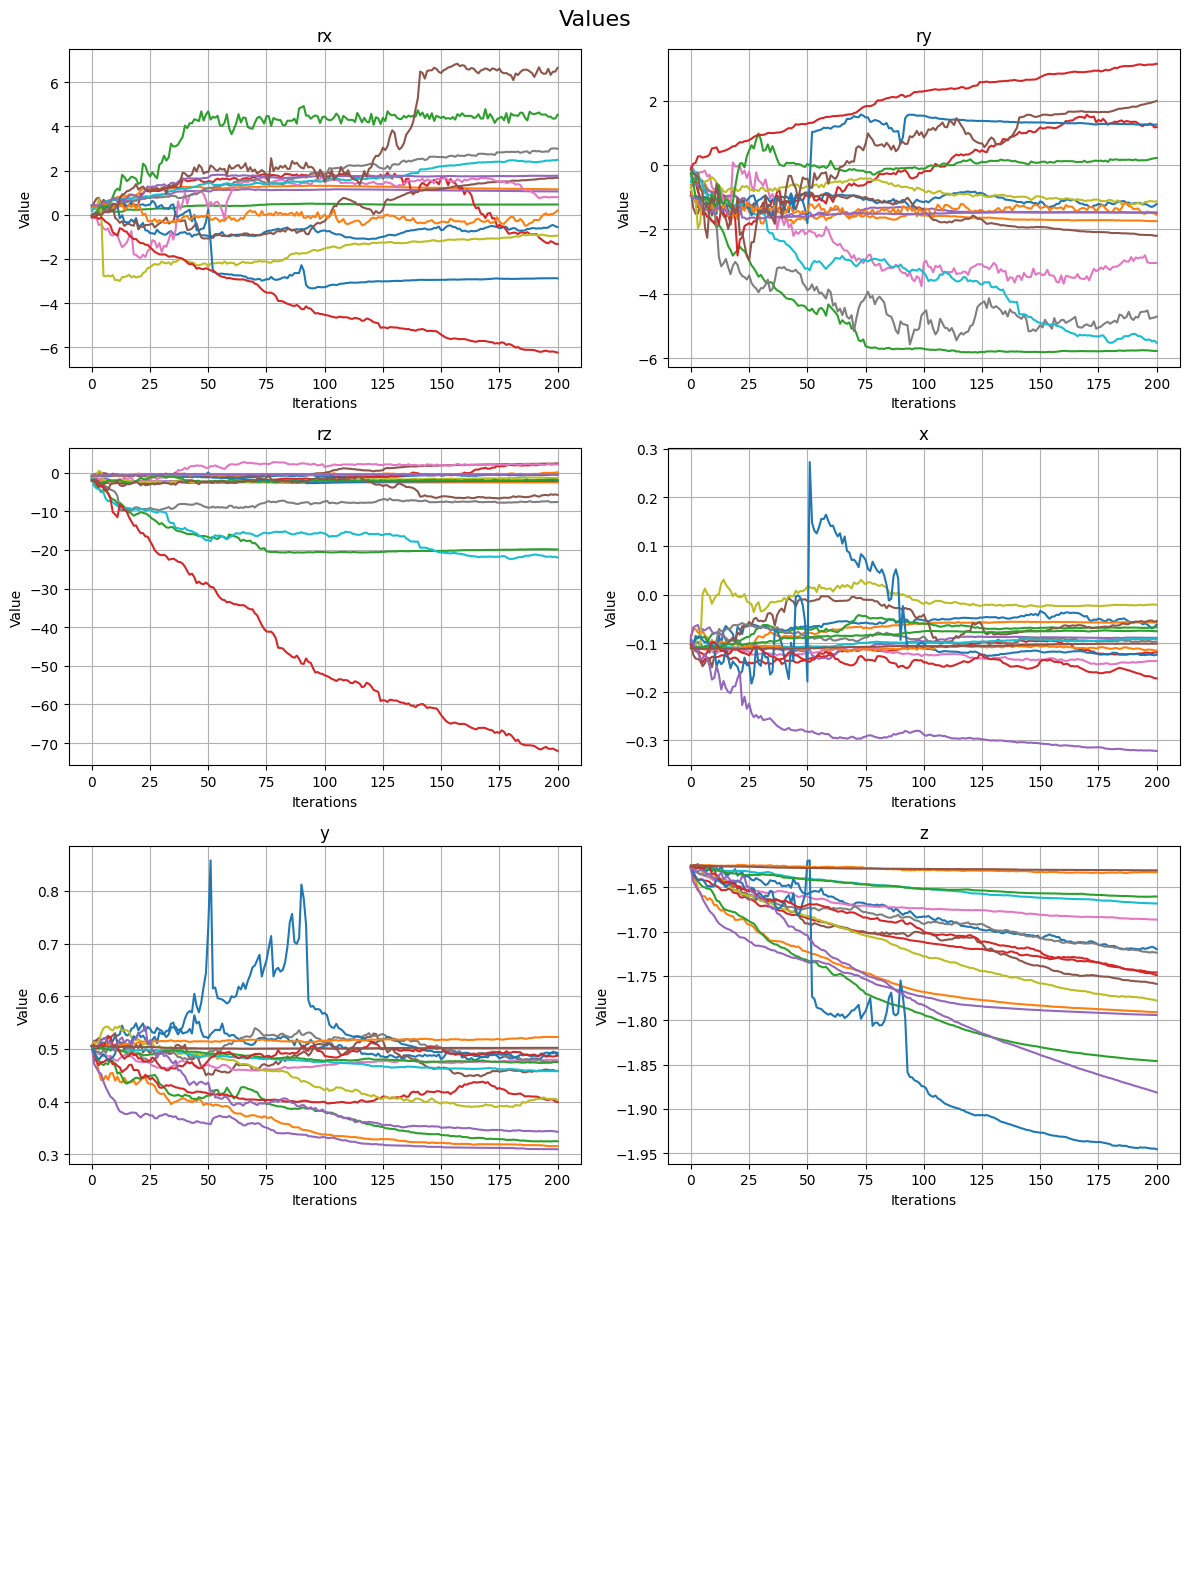

In [18]:
values = [o['values'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed
fig.suptitle('Values', fontsize=16)
for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_values = np.array([array[:, i] for array in values])  # Extract gradients for each parameter
        means = param_values.mean(1)
        ax.plot(param_values)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

### For Sanity check: Measure the loss at the ground truth

Loss at Ground Truth:
GT Raw RGB Loss:0.0
GT Raw Depth Loss:0.0
GT Raw Reconstruction Loss:0.0
GT Raw Mask Loss:0.0


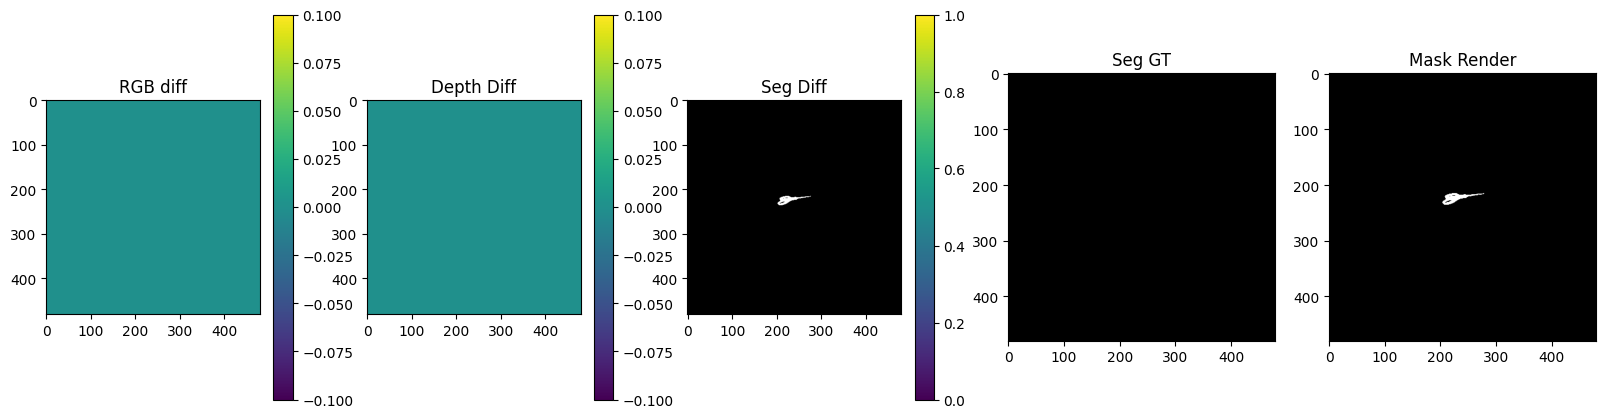

In [19]:
cfg_gt = cfg.copy()
cfg_gt['object3d']['position'] = gt_pose_cam[:3].tolist()
cfg_gt['object3d']['rotation'] = gt_pose_cam[3:].tolist()
ddope_gt = dd.DiffDope(cfg=cfg_gt)
ddope_gt.gt_tensors["rgb"] = ddope_gt.scene.tensor_rgb.img_tensor
ddope_gt.gt_tensors["depth"] = ddope_gt.scene.tensor_depth.img_tensor
ddope_gt.gt_tensors["segmentation"] = ddope_gt.scene.tensor_segmentation.img_tensor

result = ddope_gt.object3d()

if ddope_gt.object3d.rotation_mode == 'rtheta':
    mtx_gu = dd.matrix_batch_44_from_position_r(
        p=result['trans'], r=result['rtheta']
    )
else:
    mtx_gu = dd.matrix_batch_44_from_position_quat(
        p=result['trans'], q=result['quat']
    )
ddope_gt.renders = dd.render_texture_batch(
    glctx=ddope_gt.glctx,
    proj_cam=ddope_gt.camera.cam_proj,
    mtx=mtx_gu,
    pos=result["pos"],
    pos_idx=result["pos_idx"],
    uv=result["uv"],
    uv_idx=result["uv_idx"],
    tex=result["tex"],
    resolution=ddope_gt.resolution,
)
losses = ['rgb','depth','mask']
loss = torch.zeros(ddope_gt.batchsize).cuda()
to_add = {}
to_add["rgb"] = ddope_gt.renders["rgb"].detach().cpu()
to_add["depth"] = ddope_gt.renders["depth"].detach().cpu()
to_add["mtx"] = mtx_gu.detach().cpu()
ddope_gt.optimization_results.append(to_add)
print("Loss at Ground Truth:")
for i,loss_function in enumerate(ddope_gt.loss_functions):
    l = loss_function(ddope_gt)
    if l is None:
        continue
    loss += l

gt_rgb_loss = ddope_gt.losses_values['rgb'].squeeze()[0]
gt_depth_loss = ddope_gt.losses_values['depth'].squeeze()[0]
gt_reconstruct_loss = ddope_gt.losses_values['reconstructed_depth'].squeeze()[0]
gt_mask_loss = ddope_gt.losses_values['mask_selection'].squeeze()[0]
print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print(f"GT Raw Depth Loss:{gt_depth_loss}")
print(f"GT Raw Reconstruction Loss:{gt_reconstruct_loss}")
print(f"GT Raw Mask Loss:{gt_mask_loss}")

diff_rgb = torch.abs(
        (ddope_gt.renders["rgb"] - ddope_gt.gt_tensors["rgb"])
        * ddope_gt.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (ddope_gt.renders["depth"] - ddope_gt.gt_tensors["depth"])
        * ddope_gt.gt_tensors["segmentation"][..., 0]
    )

mask = ddope_gt.renders["mask"]
diff_mask = torch.abs(mask - ddope_gt.gt_tensors["segmentation"])

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')
axes[3].set_title('Seg GT')
axes[4].set_title('Mask Render')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())
axes[3].imshow(ddope_gt.gt_tensors["segmentation"][0].cpu().detach().numpy())
axes[4].imshow(mask[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

# img = ddope_gt.render_img(batch_index=0)
# plt.imshow(img)
ddope_gt.optimization_results = []